In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datamol as dm
import vae_cyc as vc
import pandas as pd 
import pytorch_lightning as pl 
import wandb
import numpy as np
from torch.utils.data import DataLoader 
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

In [3]:
# from datasets import load_dataset

# ds = load_dataset("sagawa/pubchem-10m-canonicalized")

In [4]:
df = pd.read_csv('/workspace/moses.csv')

df = df.sample(n=50000)

vocab = vc.AtomVocab(df, 'SMILES')

extracting charset with atomwise tokenizer..


100%|██████████| 50000/50000 [00:00<00:00, 133443.63it/s]


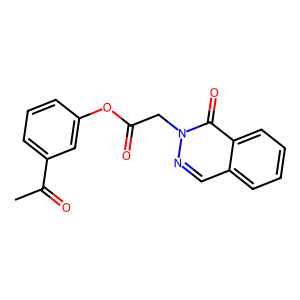

In [5]:
dm.to_image('CC(=O)c1cccc(OC(=O)Cn2ncc3ccccc3c2=O)c1')

In [6]:
vocab.char2idx

{'<sos>': 0,
 '<eos>': 1,
 '<pad>': 2,
 '<unk>': 3,
 'C': 4,
 'c': 5,
 '1': 6,
 'N': 7,
 '(': 8,
 '=': 9,
 'O': 10,
 ')': 11,
 '2': 12,
 'n': 13,
 'S': 14,
 's': 15,
 'Br': 16,
 'o': 17,
 '3': 18,
 'F': 19,
 '[nH]': 20,
 'Cl': 21,
 '4': 22,
 '-': 23,
 '#': 24,
 '[H]': 25,
 '5': 26,
 '6': 27}

In [7]:
lengths = df.SMILES.str.len()
max_len = np.max(lengths)

In [8]:
df['str_len'] = lengths
df = df[df.str_len <= 126]

In [10]:
train_df, val_df = train_test_split(df, test_size=0.001)

train_dataset = vc.TransformerSMILESDataset(train_df.SMILES.values, vocab, max_len + 1)

val_dataset = vc.TransformerSMILESDataset(val_df.SMILES.values, vocab, max_len + 1)

checkpoint_callback = ModelCheckpoint(dirpath='/workspace/moses-vae-large/', verbose=True, save_top_k=3,monitor='val/loss', every_n_train_steps=5000)

In [11]:
train_dl = DataLoader(train_dataset,batch_size=128,shuffle=True, collate_fn=train_dataset.collate,num_workers=0)
val_dl = DataLoader(val_dataset, batch_size=128, shuffle=False, collate_fn=val_dataset.collate, num_workers=0)

In [12]:
wandb_logger = WandbLogger(project="run_pod", log_model=True)
wandb.init()
# wandb_logger=None

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: rhaddad7. Use `wandb login --relogin` to force relogin


In [13]:
trainer = pl.Trainer(devices=1, logger=wandb_logger, precision='16-mixed', callbacks=[checkpoint_callback])

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [14]:
model = vc.Transformer(vocab_size=len(vocab.char2idx), 
                       num_heads=8, 
                       hidden_dim=64, 
                       num_layers=12, 
                       embed_size=128, 
                       latent_dim=128, 
                       vocab=vocab, 
                       max_seq_length=128)

here


In [ ]:
trainer.fit(model, train_dl, val_dl)

In [16]:
model = model.eval()

In [17]:
model = model.cuda()

In [18]:
import torch

In [19]:
x = torch.randint(0, vocab.vocab_size, size=(4,20))

[16:36:30] SMILES Parse Error: syntax error while parsing: CC(CCN(C(=)NC(=)c1cccc(NC(=)c2ccc2)c1
[16:36:30] SMILES Parse Error: Failed parsing SMILES 'CC(CCN(C(=)NC(=)c1cccc(NC(=)c2ccc2)c1' for input: 'CC(CCN(C(=)NC(=)c1cccc(NC(=)c2ccc2)c1'


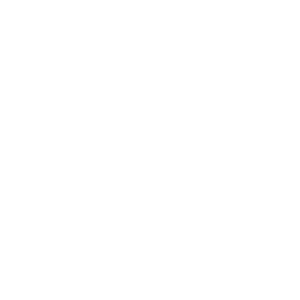

In [20]:
import datamol as dm
dm.to_image(model.generate(num_samples=1))

In [21]:
for i in range(10):
    print(model.generate(num_samples=1))

CC(CC(N)c1cccc(N(NC(=O)c2cccc2)c1
CCC(CNC(=O)c1cccc(NC(=)c2cccc2)c1
CC(CCN(C(=)c1ccccc1)c1cccc1ccc1
CC(CC(C)NC(=O)c1ccc(NC(=)cc1cccc1
CC(CCN(C(=)NC(=)c1ccccc1)c1cccc1
CC(CC(C(N)c1cccc(NC(=)(N)cc1ccc1cccc1
CC(CCN(C(=)NC(=)c1ccccc1C(N)C(C)C1
CC(CC(N)C(=O)NC(=)c1cccc(NC(=O)c1cccc1
CC(CC(N)c1cccc(N(NC(=)(N)cc1ccc1)cc1
CC(CC(N)C(=O)NC(=)c1cccc(N(=O)c1
